In [1]:
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler  # may require qiskit-aer >= 0.12
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime
from qiskit_algorithms.utils import algorithm_globals

In [2]:
# ------------------------
# PARAMETERS
# ------------------------
num_assets = 4
algorithm_globals.random_seed =  123  # reproducible data generation ## SEED ##

risk_factor = 0.5
budget = num_assets // 2
cobyla_maxiter = 200
ansatz_reps = 2
qaoa_reps = 2
cvar_alpha = 0.2  # for CVaR example (0.0-1.0). Lower alpha focuses on best outcomes.


Mean returns vector (mu):
 [ 0.01528439 -0.00078095  0.00051792  0.00087001]

Covariance matrix (sigma):
 [[ 2.54138859e-03  7.34022167e-05  1.28600531e-04 -9.98612132e-05]
 [ 7.34022167e-05  2.58486713e-04  5.30427595e-05  4.44816208e-05]
 [ 1.28600531e-04  5.30427595e-05  7.91504681e-04 -1.23887382e-04]
 [-9.98612132e-05  4.44816208e-05 -1.23887382e-04  1.97892585e-04]]


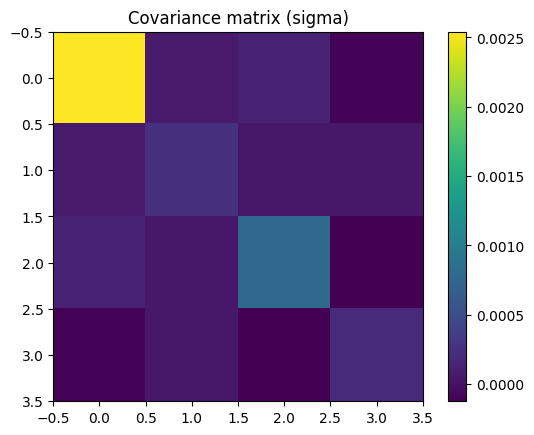

In [3]:
# ------------------------
# 1) Generate random finance data
# ------------------------
tickers = [f"TICKER{i}" for i in range(num_assets)]
data_provider = RandomDataProvider(
    tickers=tickers,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data_provider.run()

mu = data_provider.get_period_return_mean_vector()
sigma = data_provider.get_period_return_covariance_matrix()

print("Mean returns vector (mu):\n", mu)
print("\nCovariance matrix (sigma):\n", sigma)

# optional: show heatmap of covariance
try:
    plt.imshow(sigma, interpolation="nearest")
    plt.title("Covariance matrix (sigma)")
    plt.colorbar()
    plt.show()
except Exception:
    # Running in non-GUI / headless environment may fail plotting; ignore gracefully.
    pass

| Quantity               | Symbol                  | Meaning                                                             |
| ---------------------- | ----------------------- | ------------------------------------------------------------------- |
| **Mean Return Vector** | **μ = [μ₁, μ₂, …, μₙ]** | Average (expected) return of each asset                             |
| **Covariance Matrix**  | **Σ = [σᵢⱼ]**           | How each pair of assets’ returns move together (risk relationships) |


In [4]:
# ------------------------
# 2) Build the PortfolioOptimization Quadratic Program
# ------------------------
portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget)
qp = portfolio.to_quadratic_program()
print("\nQuadraticProgram built. Number of variables:", qp.get_num_vars())
print(qp.prettyprint())

# ------------------------
# Helper: pretty print solver results and probabilities
# ------------------------
def print_result(result, portfolio_obj, title="Result"):
    """
    result: result returned by MinimumEigenOptimizer.solve(qp)
    portfolio_obj: PortfolioOptimization instance (to evaluate objective for bitstrings)
    """
    print("\n" + "="*30)
    print(title)
    print("="*30)
    # selected bitstring (binary vector)
    try:
        selection = np.array(result.x, dtype=int)
    except Exception:
        selection = None

    try:
        value = result.fval
    except Exception:
        value = None

    if selection is not None:
        print("Optimal selection (solver output):", selection)
    if value is not None:
        print("Objective value (solver): {:.6f}".format(value))

    # Solve: get eigenstate distribution if present
    meo_res = getattr(result, "min_eigen_solver_result", None)
    if meo_res is None:
        print("No min_eigen_solver_result attached (classical solver or different result structure).")
        return

    eigenstate = getattr(meo_res, "eigenstate", None)
    if eigenstate is None:
        print("No eigenstate in min_eigen_solver_result.")
        return

    # Extract bitstring probabilities (works for QuasiDistribution or statevector-like)
    if isinstance(eigenstate, QuasiDistribution):
        probabilities = eigenstate.binary_probabilities()
    else:
        # eigenstate may provide .to_dict() mapping amplitudes
        try:
            amp_dict = eigenstate.to_dict()
            probabilities = {k: np.abs(v) ** 2 for k, v in amp_dict.items()}
        except Exception:
            # fallback empty
            probabilities = {}

    # Sort and print top probabilities
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
    print("\nTop measured bitstrings (bit-order: least significant bit is rightmost):")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for k, p in probabilities[:10]:
        # convert string key '0101' (big endian?) to numpy array in consistent order expected by portfolio objective
        # In Qiskit, binary strings usually are big-endian (leftmost is qubit 0). We reverse to match portfolio variable order if needed.
        bitstr = k
        # Convert to array of ints; reverse to match earlier code convention (it used reversed(k))
        arr = np.array([int(i) for i in list(reversed(bitstr))])
        val = portfolio_obj.to_quadratic_program().objective.evaluate(arr)
        print("%10s\t%.6f\t%.6f" % (arr, val, p))


QuadraticProgram built. Number of variables: 4
Problem name: Portfolio optimization

Minimize
  0.001270694296030004*x_0^2 + 7.34022166934733e-05*x_0*x_1
  + 0.00012860053085450988*x_0*x_2 - 9.986121318021848e-05*x_0*x_3
  + 0.00012924335651113268*x_1^2 + 5.304275948260219e-05*x_1*x_2
  + 4.4481620835391664e-05*x_1*x_3 + 0.0003957523406615203*x_2^2
  - 0.00012388738164026145*x_2*x_3 + 9.89462926895246e-05*x_3^2
  - 0.015284386651719337*x_0 + 0.0007809521451492393*x_1
  - 0.0005179205467023194*x_2 - 0.0008700058372126832*x_3

Subject to
  Linear constraints (1)
    x_0 + x_1 + x_2 + x_3 == 2  'c0'

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [5]:
# ------------------------
# 3) Run Classical baseline: NumPyMinimumEigensolver
# ------------------------
print("\nRunning classical NumPyMinimumEigensolver (exact diagonalization) ...")
classical_solver = NumPyMinimumEigensolver()
meo_classical = MinimumEigenOptimizer(classical_solver)
try:
    result_classical = meo_classical.solve(qp)
    print_result(result_classical, portfolio, title="Classical NumPyMinimumEigensolver")
except Exception as e:
    print("Classical solver failed:", e)



Running classical NumPyMinimumEigensolver (exact diagonalization) ...

Classical NumPyMinimumEigensolver
Optimal selection (solver output): [1 0 0 1]
Objective value (solver): -0.014885

Top measured bitstrings (bit-order: least significant bit is rightmost):
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.014885	1.000000


In [6]:
# ------------------------
# 4) Prepare sampler and optimizers (try to use Sampler from qiskit-aer)
# ------------------------
try:
    sampler = Sampler()  # default local Aer's Sampler primitive
    print("\nUsing qiskit_aer.primitives.Sampler as backend.")
except Exception as exc:
    sampler = None
    print("\nWarning: qiskit_aer.primitives.Sampler is not available. Sampler algorithms may fail. Error:", exc)
    print("If you want to run quantum algorithms locally, install qiskit-aer and qiskit-runtime components.")



Using qiskit_aer.primitives.Sampler as backend.


In [7]:
# ------------------------
# 5) Sampling-VQE run
# ------------------------
print("\nSetting up SamplingVQE (VQE) ...")
ansatz = TwoLocal(num_assets, rotation_blocks="ry", entanglement_blocks="cz", reps=ansatz_reps, skip_final_rotation_layer=False)
optimizer = COBYLA(maxiter=cobyla_maxiter)

try:
    if sampler is None:
        raise RuntimeError("Sampler backend not available.")

    vqe = SamplingVQE(sampler=sampler, ansatz=ansatz, optimizer=optimizer)
    meo_vqe = MinimumEigenOptimizer(vqe)
    result_vqe = meo_vqe.solve(qp)
    print_result(result_vqe, portfolio, title="SamplingVQE (ansatz: TwoLocal, optimizer: COBYLA)")
except Exception as e:
    print("SamplingVQE failed (likely backend/installation issue):", e)
    print("You can still run VQE using simulators/backends by installing qiskit-aer or using Qiskit Runtime.")

# Optional: a simple CVaR-ish post-processing demonstration using the returned eigenstate
# (This is a demonstration of computing CVaR on measured distribution if available.)
def compute_cvar_from_distribution(eigenstate, portfolio_obj, alpha=0.2):
    """
    Given a QuasiDistribution-like eigenstate, compute CVaR_alpha:
      - gather (bitstring, energy, prob)
      - sort by energy ascending
      - take lowest-alpha cumulative probability mass (or lowest alpha fraction of samples)
      - compute weighted-average energy of that set (CVaR estimate)
    """
    if eigenstate is None:
        return None

    if isinstance(eigenstate, QuasiDistribution):
        probs = eigenstate.binary_probabilities()
    else:
        try:
            amp_dict = eigenstate.to_dict()
            probs = {k: np.abs(v) ** 2 for k, v in amp_dict.items()}
        except Exception:
            return None

    items = []
    for k, p in probs.items():
        arr = np.array([int(i) for i in list(reversed(k))])
        val = portfolio_obj.to_quadratic_program().objective.evaluate(arr)
        items.append((k, val, p))
    # sort by value ascending (lower is better)
    items.sort(key=lambda x: x[1])
    # pick lowest-alpha fraction by cumulative probability
    cumsum = 0.0
    selected = []
    for k, val, p in items:
        selected.append((k, val, p))
        cumsum += p
        if cumsum >= alpha:
            break
    if len(selected) == 0:
        return None
    # weighted average of selected energies (normalize by selected total prob)
    total_prob = sum(p for (_, _, p) in selected)
    cvar = sum(val * p for (_, val, p) in selected) / total_prob
    return cvar, selected

# If we have a vqe result with eigenstate, compute CVaR
try:
    vqe_eigenstate = result_vqe.min_eigen_solver_result.eigenstate
    cvar_val = compute_cvar_from_distribution(vqe_eigenstate, portfolio, alpha=cvar_alpha)
    if cvar_val is not None:
        cvar_estimate, selected_bits = cvar_val
        print(f"\nEstimated CVaR (alpha={cvar_alpha}): {cvar_estimate:.6f}")
        print("Bitstrings used for CVaR estimate (bitstr, energy, prob):")
        for k, val, p in selected_bits:
            print(k, val, p)
except Exception:
    # either vqe failed earlier or structure is different
    pass



Setting up SamplingVQE (VQE) ...

SamplingVQE (ansatz: TwoLocal, optimizer: COBYLA)
Optimal selection (solver output): [1 0 0 1]
Objective value (solver): -0.014885

Top measured bitstrings (bit-order: least significant bit is rightmost):
selection	value		probability
---------------------------------------------------
 [0 1 1 0]	0.000841	0.646484
 [0 0 1 1]	-0.001017	0.217773
 [1 0 1 0]	-0.014007	0.073242
 [0 1 0 0]	0.000910	0.025391
 [1 0 1 1]	-0.015002	0.015625
 [1 1 0 0]	-0.013030	0.011719
 [1 0 0 1]	-0.014885	0.004883
 [0 1 0 1]	0.000184	0.003906
 [0 1 1 1]	-0.000009	0.000977

Estimated CVaR (alpha=0.2): -0.005282
Bitstrings used for CVaR estimate (bitstr, energy, prob):
1101 -0.015002068170219261 0.015625
1001 -0.01488461311339271 0.0048828125
0101 -0.014007260030875622 0.0732421875
0011 -0.013030094637335487 0.01171875
1100 -0.001017115132204219 0.2177734375


In [8]:
# ------------------------
# 6) QAOA run
# ------------------------
print("\nSetting up QAOA ...")
try:
    if sampler is None:
        raise RuntimeError("Sampler backend not available.")

    qaoa_optimizer = COBYLA(maxiter=cobyla_maxiter)
    qaoa = QAOA(sampler=sampler, optimizer=qaoa_optimizer, reps=qaoa_reps)
    meo_qaoa = MinimumEigenOptimizer(qaoa)
    result_qaoa = meo_qaoa.solve(qp)
    print_result(result_qaoa, portfolio, title=f"QAOA (reps={qaoa_reps}, optimizer=COBYLA)")
except Exception as e:
    print("QAOA failed (likely backend/installation issue):", e)

# ------------------------
# DONE
# ------------------------
print("\nAll done. Compare the printed selections and objective values across solvers to evaluate performance.")



Setting up QAOA ...

QAOA (reps=2, optimizer=COBYLA)
Optimal selection (solver output): [1 0 0 1]
Objective value (solver): -0.014885

Top measured bitstrings (bit-order: least significant bit is rightmost):
selection	value		probability
---------------------------------------------------
 [0 0 1 1]	-0.001017	0.176758
 [1 0 1 0]	-0.014007	0.175781
 [1 1 0 0]	-0.013030	0.173828
 [1 0 0 1]	-0.014885	0.171875
 [0 1 0 1]	0.000184	0.150391
 [0 1 1 0]	0.000841	0.147461
 [0 0 1 0]	-0.000122	0.000977
 [1 0 1 1]	-0.015002	0.000977
 [1 1 0 1]	-0.013857	0.000977
 [0 0 0 1]	-0.000771	0.000977

All done. Compare the printed selections and objective values across solvers to evaluate performance.
